# Time Series Clustering

In this notebook we're going to look into this models to compute clusters for a time series data
* Time Series KMeans
* Gaussian Mixture Models
* SVM clustering with Time Series Cluster Kernel (TCK)
* Hierarchial Clustering
* Reservoir computing with Hierarchical clustering

We're going to evaluate the models based on these metrics:
* Normalized Mutual Info score
* Adjusted Rand score
* V Measure score
* Silhouette score
* Davies Bouldin score
* Calinski Harabasz score

Out of these metrics these ones are specifically to calculate how "good" the computed clusters are:
* Silhouette score
* Davies Bouldin score
* Calinski Harabasz score

I'm also going to visualize all the clusters for each model to be able to vividly see the difference.
For most of the model I'm using Dynamic Time Warping to calculate the distances between time series, more about that here
https://www.geeksforgeeks.org/machine-learning/dynamic-time-warping-dtw-in-time-series/

In [1]:
!pip install tslearn
!pip install dtaidistance
!pip install tck
!pip install reservoir_computing

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib as mpl

from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw

from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis

from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, v_measure_score, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd

from tck.TCK import TCK

from reservoir_computing.modules import RC_model

import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/tck/TCK.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Loading the Dataset and visualizing it

Dataset shapes
 X_train: (100, 275, 1)
 Y_train: (100,)
 X_test: (100, 275, 1)
 Y_test: (100,)

Y_train unique values:  [1 2 3 4]

X_train NaNs:  0
X_test NaNs:  0

X_train_scaled shape:  (100, 275, 1)


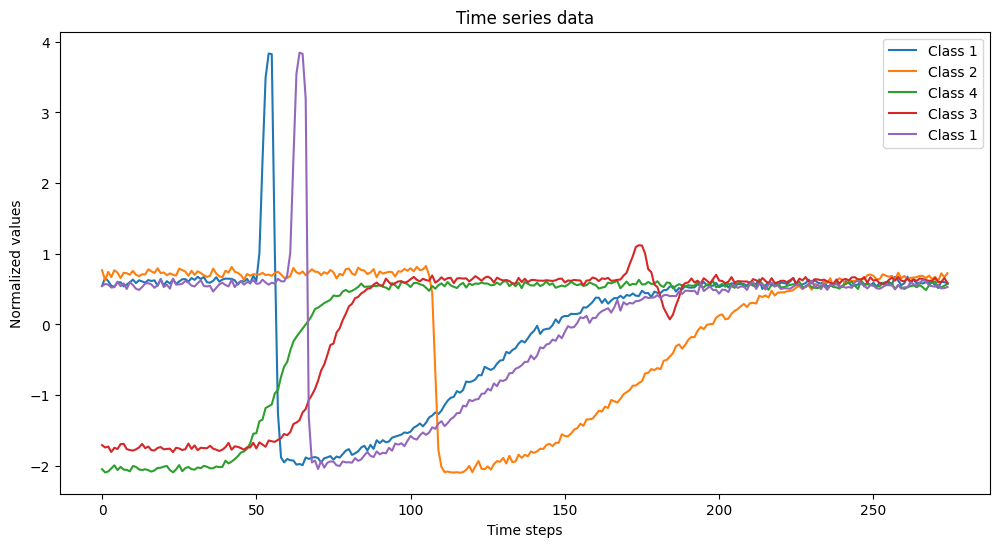

In [2]:
X_train, Y_train, X_test, Y_test = CachedDatasets().load_dataset("Trace") 

print("Dataset shapes")
print(f" X_train: {X_train.shape}\n Y_train: {Y_train.shape}\n X_test: {X_test.shape}\n Y_test: {Y_test.shape}")

print("\nY_train unique values: " ,np.unique(Y_train))
n_label = len(np.unique(Y_train))

print("\nX_train NaNs: ", np.isnan(X_train).sum())
print("X_test NaNs: ", np.isnan(X_test).sum())

scaler = TimeSeriesScalerMeanVariance() # models are sensitive to unscaled data
X_train_scaled = scaler.fit_transform(X_train)

print("\nX_train_scaled shape: ", X_train_scaled.shape)

plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(X_train_scaled[i].ravel(), label=f"Class {Y_train[i]}")

plt.title("Time series data")
plt.xlabel("Time steps")
plt.ylabel("Normalized values")

plt.legend()
plt.show()

# Time Series KMeans Clustering

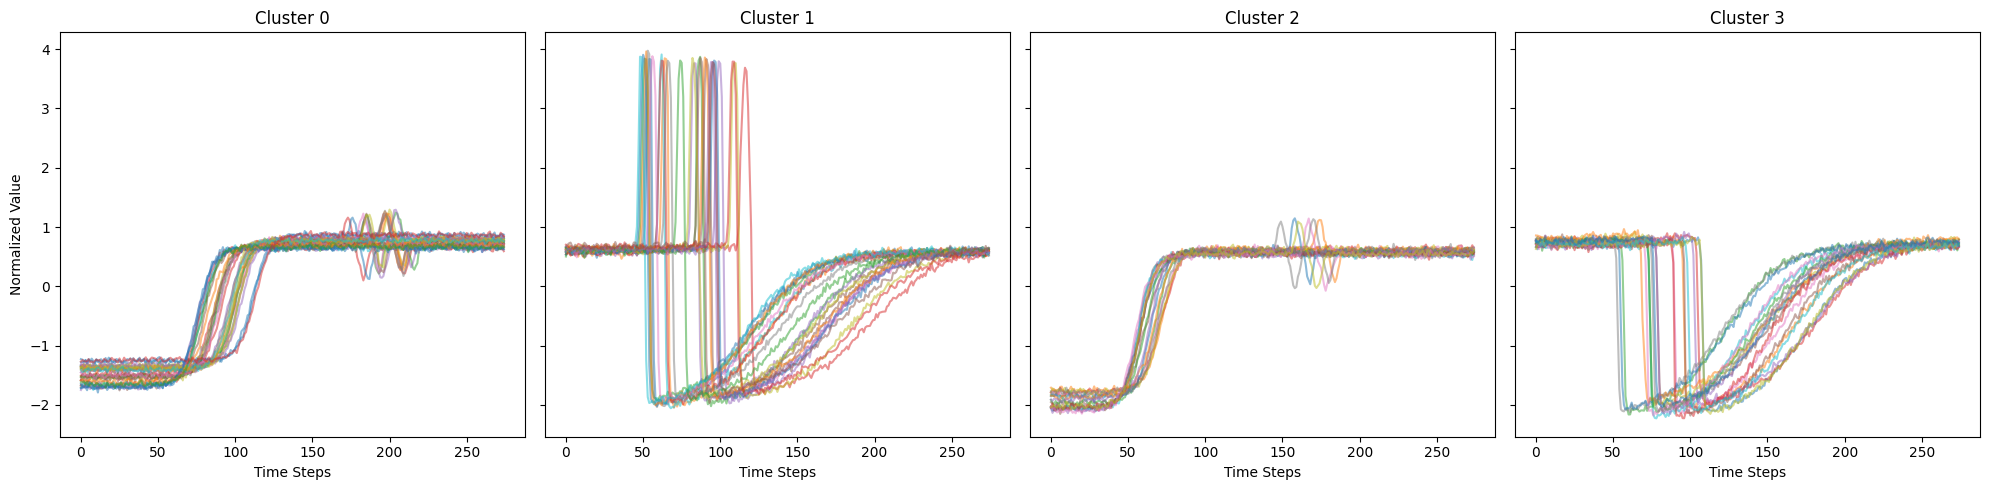

Number of time series per cluster: 
0    34
1    26
3    21
2    19
Name: count, dtype: int64

Results for TimeSeriesKMeans Clustering with DTW
External metrics
NMI: 0.746, ARI: 0.627, V-measure: 0.746
Internal Metrics
Silhouette: 0.671, DB: 2.979, CH: 72.245


In [3]:
# Function to compute eval metrics for given cluster
def get_metrics(X, y_pred, y_true):
    # Compute DTW distance matrix
    X_2d = X.reshape(X.shape[0], -1) if X.ndim > 2 else X
    D = cdist_dtw(X_2d)
    
    nmi = normalized_mutual_info_score(y_true, y_pred) # NMI score
    ari = adjusted_rand_score(y_true, y_pred) # ARI score
    v = v_measure_score(y_true, y_pred) # V Measure score
    
    sil = silhouette_score(D, labels, metric="precomputed") # Silhouette score
    db = davies_bouldin_score(X_2d, y_pred) # Davies Bouldin score
    ch = calinski_harabasz_score(X_2d, y_pred) # Calinski Harabasz score

    print(f"External metrics")
    print(f"NMI: {nmi:.3f}, ARI: {ari:.3f}, V-measure: {v:.3f}")
    print(f"Internal Metrics")
    print(f"Silhouette: {sil:.3f}, DB: {db:.3f}, CH: {ch:.3f}")

    metrics = {
        'nmi' : nmi,
        'ari' : ari,
        'v' : v,
        'sil' : sil,
        'db' : db,
        'ch' : ch
    }

    return metrics

# Time Series KMeans Model

n_clusters = 4
model = TimeSeriesKMeans(n_clusters, metric="dtw", random_state=42)
labels = model.fit_predict(X_train_scaled)

clustered_data = pd.DataFrame({
    "Time_Series" : X_train_scaled.tolist(),
    "Clusters" : labels
})

# Plot the clusters
n_clusters = len(set(labels))
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)

for cluster_id, ax in zip(range(n_clusters), axes):
    cluster_data = X_train_scaled[labels == cluster_id]

    for series in cluster_data:
        ax.plot(series.ravel(), alpha=0.5)

    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("Time Steps")
    if cluster_id == 0:
        ax.set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

cluster_counts = pd.Series(labels).value_counts()
print("Number of time series per cluster: ")
print(cluster_counts)

print("\nResults for TimeSeriesKMeans Clustering with DTW")
tskmeans_metrics = get_metrics(X_train_scaled.reshape(100, 275), labels, Y_train)

We can see that kmeans did a great job at computing clusters for our data, the metrics are fine and we can see visually that they are seperated very logically

# Gaussian Mixture Model

GMM clustering with 2 componenets: 



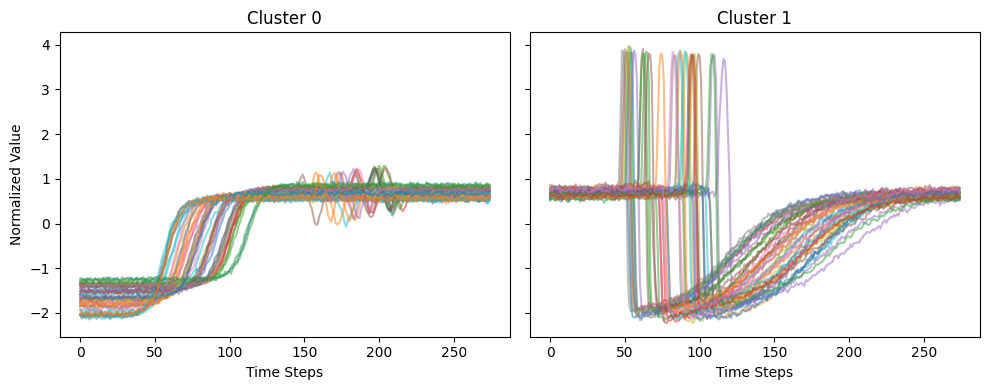

External metrics
NMI: 0.669, ARI: 0.502, V-measure: 0.669
Internal Metrics
Silhouette: 0.671, DB: 0.684, CH: 178.536

 ######################################################################################################################## 


GMM clustering with 3 componenets: 



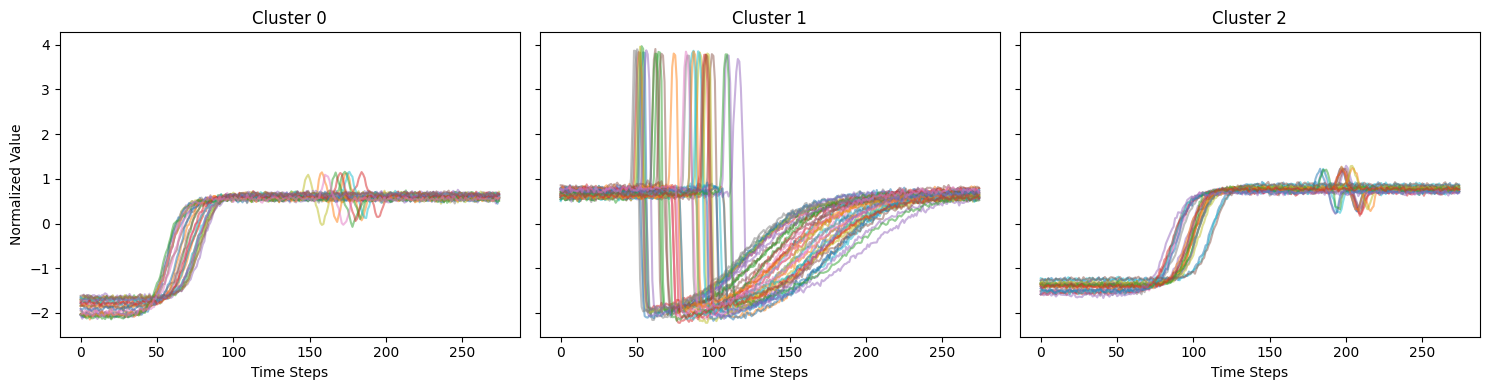

External metrics
NMI: 0.575, ARI: 0.419, V-measure: 0.575
Internal Metrics
Silhouette: 0.671, DB: 0.665, CH: 106.902

 ######################################################################################################################## 


GMM clustering with 4 componenets: 



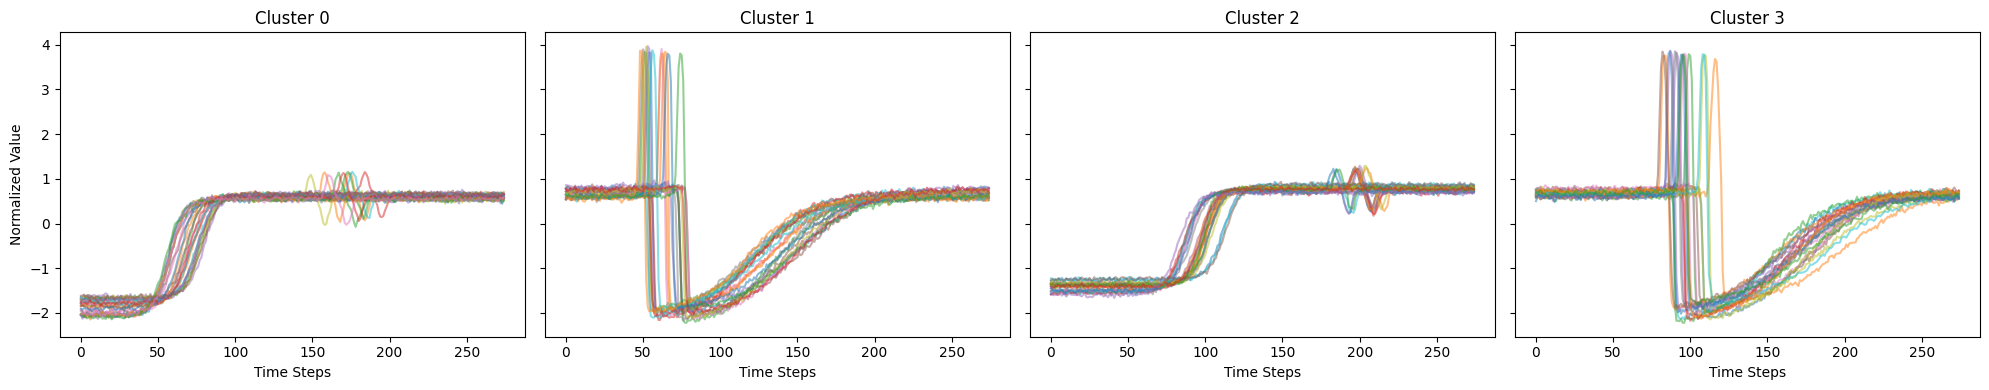

External metrics
NMI: 0.509, ARI: 0.331, V-measure: 0.509
Internal Metrics
Silhouette: 0.671, DB: 0.885, CH: 142.641

 ######################################################################################################################## 




In [4]:
gmm_metrics = []

def plot_gmm(X, y, n_components, ax=None):
    # GMM model
    gmm = GaussianMixture(n_components=n_components, covariance_type="full", random_state=0)
    gmm.fit(X)
    clusters = gmm.predict(X)

    print(f"GMM clustering with {n_components} componenets: \n")
    
    # Plot the GMM cluster
    n_clusters = len(set(clusters))
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 4), sharey=True)
    
    for cluster_id, ax in zip(range(n_clusters), axes):
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_data = X[cluster_indices]
        
        for series in cluster_data:
            ax.plot(series.ravel(), alpha=0.5)
        
        ax.set_title(f"Cluster {cluster_id}")
        ax.set_xlabel("Time Steps")
        if cluster_id == 0:
            ax.set_ylabel("Normalized Value")
    
    plt.tight_layout()
    plt.show()
    
    gmm_metrics.append(get_metrics(X, clusters, y))

    print(f"\n {'#'*120} \n\n")

# Try the GMM models with 2, 3 and 4 componenets
for i, n in enumerate([2, 3, 4]):
    plot_gmm(X_train.reshape(100, 275), Y_train, n, ax=axes[i])
    axes[i].set_title(f"GMM with $C$={n} components")

* From the visuals and metrics we can see that the GMM model with 3 componenets is the best one
* Overall The GMM models all did great for all number of components

# Time Series Cluster Kernel (TCK)


> The Time Series Cluster Kernel (TCK) is a kernel similarity for multivariate time series with missing values. Once computed, the kernel can be used to perform tasks such as classification, clustering, and dimensionality reduction.

<img src="https://filippomb.github.io/python-time-series-handbook/_images/tck_scheme.png" width="800">

> TCK is based on an ensemble of Gaussian Mixture Models (GMMs) for time series. The GMMs use time-varying means to handle time dependencies and informative Bayesian priors to handle missing values. The similarity between two time series is proportional to the number of times they are assigned to the same mixtures.

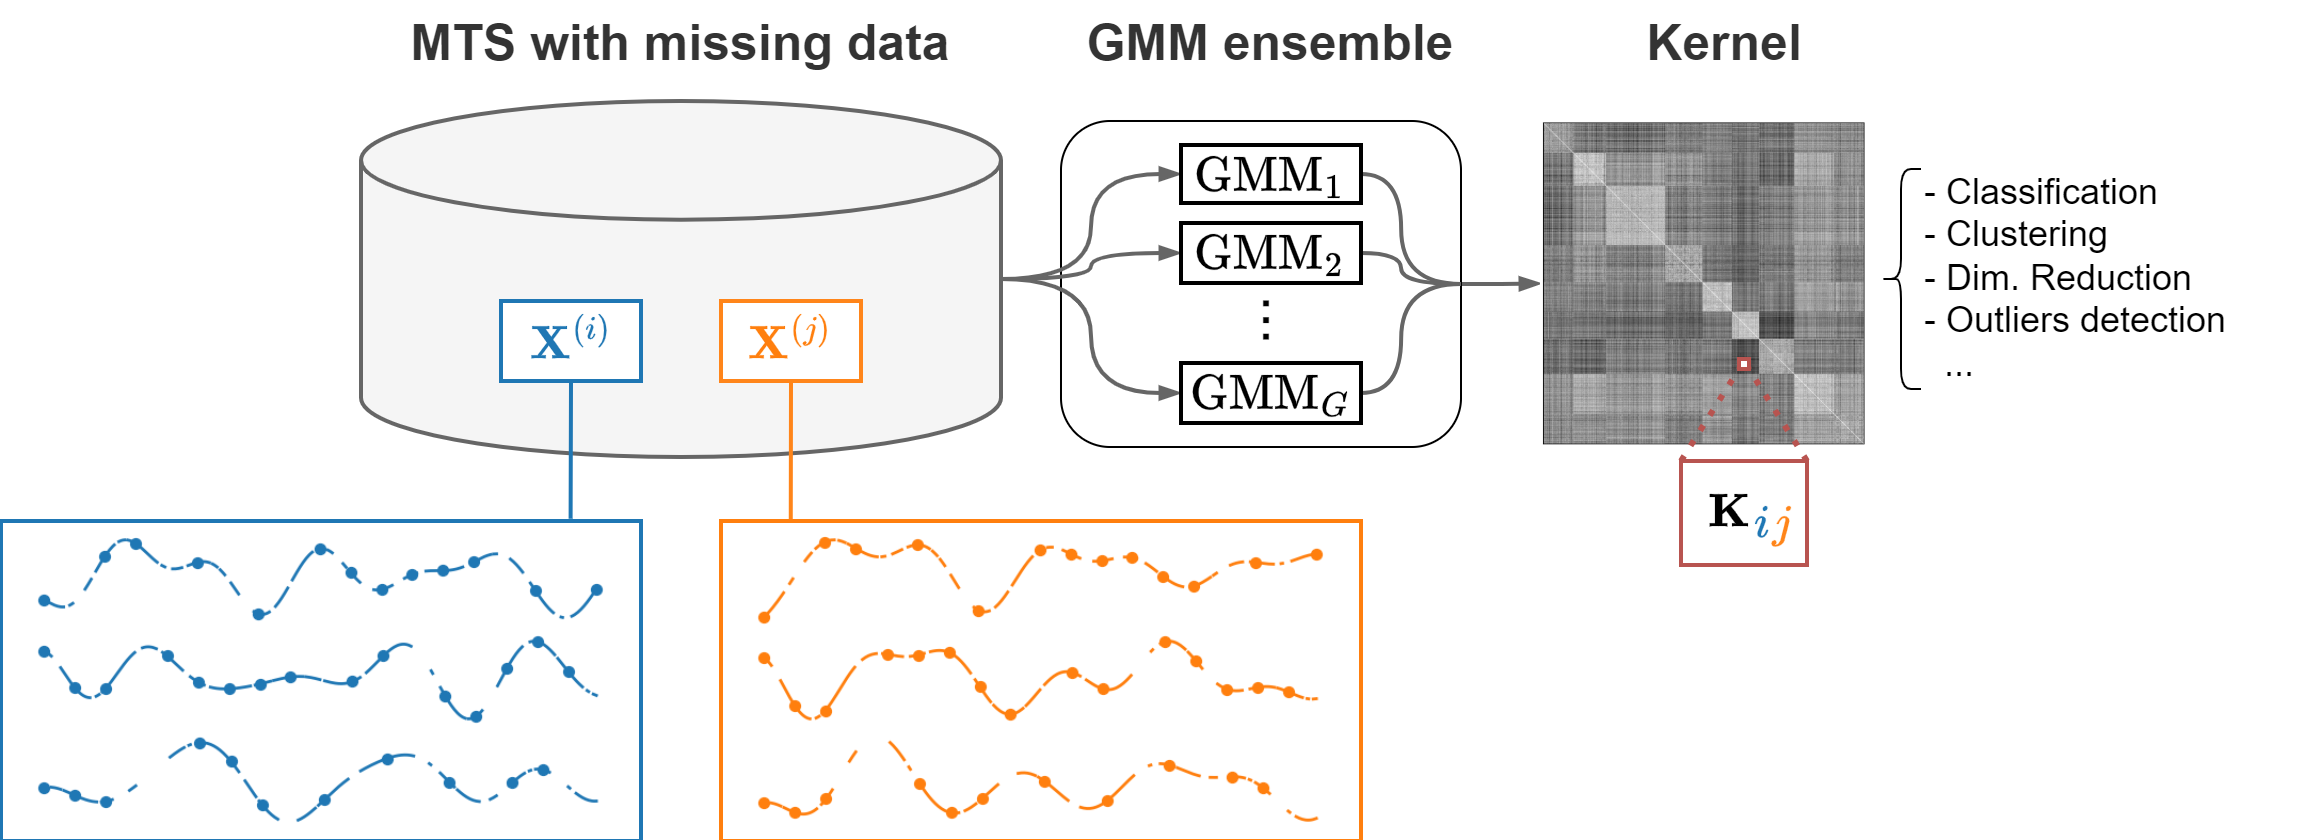

The dataset does not contain missing data

Training the TCK using the following parameters:
	C = 4, G = 10
	Number of MTS for each GMM: 80 - 100 (80 - 100 percent)
	Number of attributes sampled from [1, 1]
	Length of time segments sampled from [6, 25]




Fitting GMMs:   0%|          | 0/30 [00:00<?, ?it/s]

Computing TCK (tr-tr):   0%|          | 0/30 [00:00<?, ?it/s]

Computing TCK (tr-te):   0%|          | 0/30 [00:00<?, ?it/s]

Ktr shape: (100, 100)
Kte shape: (100, 100)
 Test accuracy: 0.75


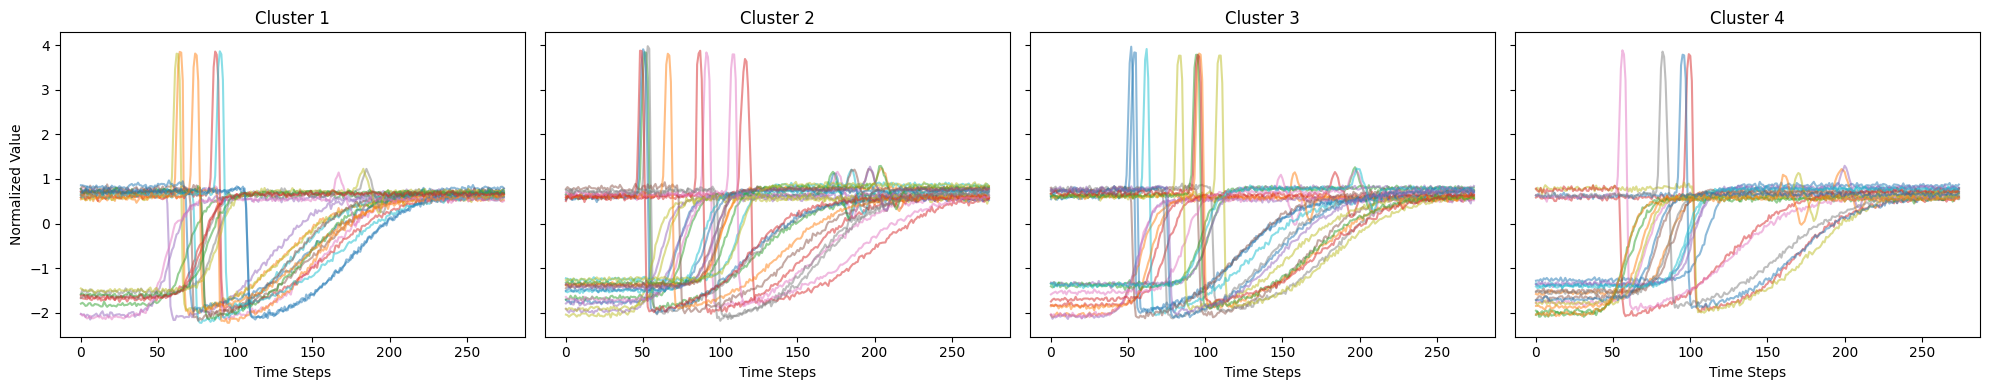

Results for TCK
External metrics
NMI: 0.059, ARI: 0.023, V-measure: 0.059
Internal Metrics
Silhouette: 0.671, DB: 8.977, CH: 1.849


In [5]:
# TCK model
tck = TCK(G=10, C=4)
Ktr = tck.fit(X_train).predict(mode='tr-tr')
Kte = tck.predict(Xte=X_test, mode='tr-te').T

print(f"Ktr shape: {Ktr.shape}\nKte shape: {Kte.shape}")

# Train a SVM model to compute the clusters with time series cluster kernel
clf = svm.SVC(kernel='precomputed').fit(Ktr, Y_train.ravel()) # Train
Ypred = clf.predict(Kte) # Test
print(f" Test accuracy: {accuracy_score(Y_test, Ypred):.2f}") 

# Plot the clusters
n_clusters = len(set(Ypred))
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 4), sharey=True)

for cluster_id, ax in zip(range(1, n_clusters + 1), axes):
    cluster_indices = np.where(Ypred == cluster_id)[0]
    cluster_data = X_train_scaled[cluster_indices]

    for series in cluster_data:
        ax.plot(series.ravel(), alpha=0.5)

    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("Time Steps")
    if cluster_id == 1:
        ax.set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

print("Results for TCK")
tck_metrics = get_metrics(X_train_scaled.reshape(100, 275), Ypred, Y_train)

* SVM clustering with Time Series CLuster Kernel didn't do great, both visually and by eval. metrics.
* You can tweak the hyperparameters of the TCK ( generally higher the values the better, but with higher numbers it ws taking very long for me )


# Hierarchial Clustering

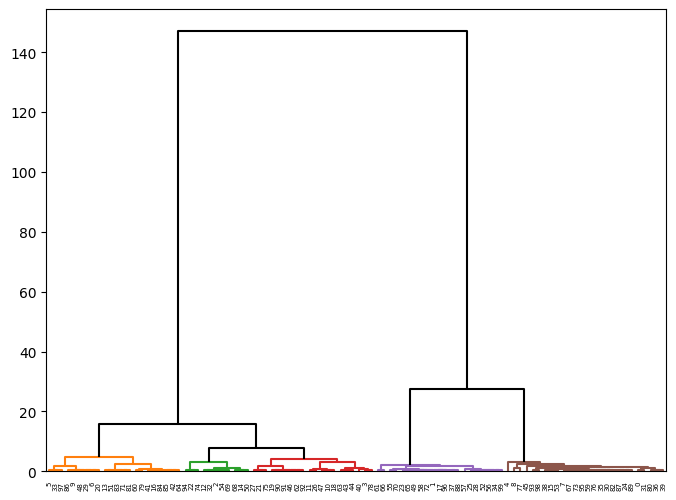

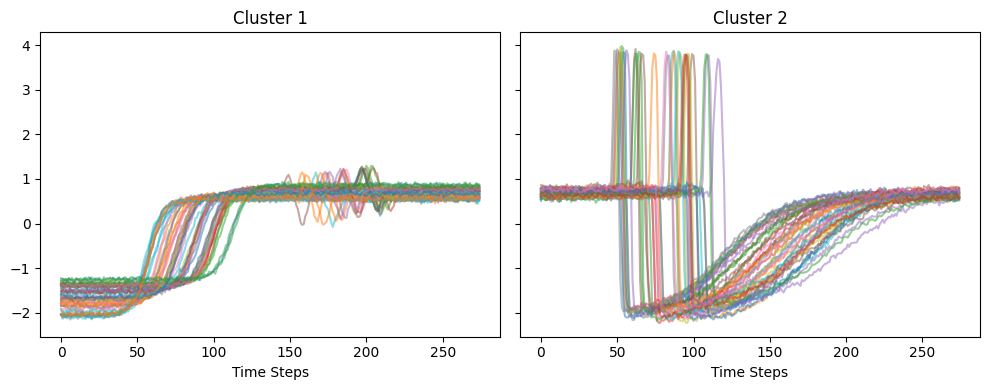

Results Hierarchy Clustering
External metrics
NMI: 0.669, ARI: 0.502, V-measure: 0.669
Internal Metrics
Silhouette: 0.671, DB: 0.684, CH: 178.536


In [6]:
# Calculate the DTW
dtw_dist = dtw_ndim.distance_matrix_fast(X_train)

distArray = ssd.squareform(dtw_dist)
Z = linkage(distArray, 'ward') 

# Plot the hierarchy tree

fig = plt.figure(figsize=(8, 6))
dn = dendrogram(Z, color_threshold=5, above_threshold_color='k', 
                show_leaf_counts=False)
plt.show()

# Get the clusters
partition = fcluster(Z, t=55, criterion="distance")

# Plot the clusters

n_clusters = len(set(partition))
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 4), sharey=True)

for cluster_id, ax in zip(range(1, n_clusters+1), axes):
    cluster_data = X_train_scaled[partition == cluster_id]
    
    for series in cluster_data:
        ax.plot(series.ravel(), alpha=0.5)
    
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("Time Steps")
    if cluster_id == 0:
        ax.set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

print("Results Hierarchy Clustering")
hc_metrics = get_metrics(X_train_scaled.reshape(100, 275), partition, Y_train)

* Hierarchial Clustering did great job. We can see that clustering are fine visually and the metrics are great
* The model is very fast

# Reservoir computing with Hierarchical clustering

for this example we will rely on Reservoir computing https://reservoir-computing.readthedocs.io/en/latest/

<img src="https://filippomb.github.io/python-time-series-handbook/_images/RC_classifier.png" width="800">


Training completed in 0.00 min
Found 2 clusters


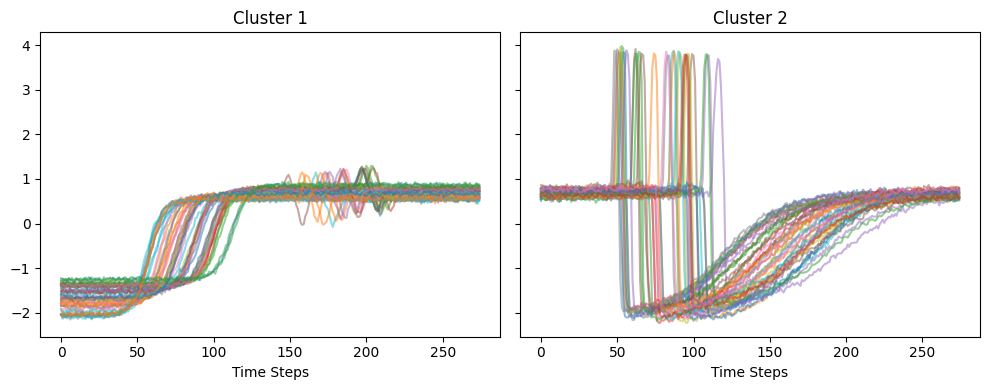


Results for RC Model with Hierarchical clustering
External metrics
NMI: 0.127, ARI: 0.103, V-measure: 0.127
Internal Metrics
Silhouette: 0.671, DB: 2.055, CH: 18.297


In [7]:
config = {
    'n_internal_units': 150,     # smaller reservoir is enough
    'spectral_radius': 1.1,      # slightly > 1 often to capture richer dynamics
    'leak': 0.3,                 # small leakage to stabilize memory
    'connectivity': 0.1,         # sparse reservoir
    'input_scaling': 0.5,        # stronger input effect
    'noise_level': 0.001,        # less noise for stability
    'n_drop': 10,                # drop a few transient states
    'bidir': False,              # Trace is unidirectional → no need for bidir
    'circle': False,
    'dimred_method': None,       # no PCA/tenPCA — preserve full reservoir info
    'n_dim': None,
    'mts_rep': 'mean',           # use the mean of reservoir states (more stable)
    'w_ridge_embedding': 1.0,
    'readout_type': None,
    'w_ridge': 1.0
}

# Instantiate the RC model
rcm =  RC_model(**config)

# Generate representations of the input MTS
rcm.fit(X_train_scaled)
mts_representations = rcm.input_repr

# Compute Dissimilarity matrix
Dist = cosine_distances(mts_representations)
distArray = ssd.squareform(Dist)

# Hierarchical clustering
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=5.0, criterion="distance")
print(f"Found {len(np.unique(clust))} clusters")

# Plot the clusters
n_clusters = len(set(clust))
fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 4), sharey=True)

for cluster_id, ax in zip(range(1, n_clusters+1), axes):
    cluster_data = X_train_scaled[partition == cluster_id]
    
    for series in cluster_data:
        ax.plot(series.ravel(), alpha=0.5)
    
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("Time Steps")
    if cluster_id == 0:
        ax.set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

print(f"\nResults for RC Model with Hierarchical clustering")
rc_metrics = get_metrics(X_train_scaled.reshape(100, 275), clust, Y_train)

* Reservoir computing with Hierarchical clustering did moderatly good visually
* We can see a huge drop in CH metric
* Model is not rapid

# Evaluation

In this part I defined functions for metric evaluation for the aforementioned models 

In [8]:
tskmeans_metrics['name'] = 'Time Series KMeans'
gmm_metrics[0]['name'] = 'GMM with 2 components'
gmm_metrics[1]['name'] = 'GMM with 3 components'
gmm_metrics[2]['name'] = 'GMM with 4 components'
tck_metrics['name'] = 'TCK'
hc_metrics['name'] = 'Hierarchial Clustering'
rc_metrics['name'] = 'RC + HC'

def pick_best_model(metrics_list):
    """
    Evaluate clustering results for time series from all the metrics
    """
    
    best_score = -np.inf
    best_index = -1

    for i, metrics in enumerate(metrics_list):
        # Normalize metrics so higher = better
        db_score = 1 / (1 + metrics['db'])  # lower DB is better
        score = (
            metrics['nmi'] +
            metrics['ari'] +
            metrics['v'] +
            metrics['sil'] +
            db_score +
            metrics['ch'] / (metrics['ch'] + 1)  # normalize CH to <1
        )
        if score > best_score:
            best_score = score
            best_index = i

    return best_index, best_score

def rank_clusters(metrics_list):
    """
    Rank clustering models based on silhouette, Davies-Bouldin, and Calinski-Harabasz.
    """
    best_score = -np.inf
    best_index = -1

    for i, metrics in enumerate(metrics_list):
        # Invert DB so higher is better
        db_score = 1 / (1 + metrics['db'])
        # Normalize CH to a value < 1
        ch_score = metrics['ch'] / (metrics['ch'] + 1)
        # Combine metrics (simple sum, can add weights)
        combined_score = metrics['sil'] + db_score + ch_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_index = i

    return best_index, best_score

model_metrics = [tskmeans_metrics, gmm_metrics[0], gmm_metrics[1], gmm_metrics[2], tck_metrics, hc_metrics, rc_metrics]

best_index, best_score = pick_best_model(model_metrics)

print("Best Model across all metrics: ", model_metrics[best_index]['name'], best_score)

best_index, best_score = rank_clusters(model_metrics)

print("Best model based on clustering metrics: ", model_metrics[best_index]['name'], best_score)

Best Model across all metrics:  Hierarchial Clustering 4.099844511823174
Best model based on clustering metrics:  GMM with 3 components 2.2620159500765284


From the results gathered from all the metrics we can see that the Hierarchial Clustering was the best clustering method for this problem, although it must be noted that tweaking the hyperparamets of other models might give better results.

But, if we consider only cluster metrics, the GMM model with 3 componenets gave the best results.

It is worth to note that only KMeans was able to differentiate the series with only "drop", other models just stacked it with the "up" then "down" ones.

Overall both Hierarchial Clustering and Gaussian Mixture Model are fine choices for this task, as well as KMeans.